# Bonus1: Parallel Algorithms

### Name: [Haihan Hu]


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('/Users/shirleyhu/Documents/GitHub/CS583-2020S/homework/Bonus1/diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[ 0.09203579  0.11798655  0.15407154 -0.03566845  0.00191325  0.03096073
  -0.02264842  0.00974766]]
test std = 
[[1.03700466 1.06240542 0.81732097 0.99810084 0.95793568 0.94586562
  0.82413056 1.02585615]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


## 2. Design worker nodes and the server

In [29]:
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x)
    yxw = numpy.dot(yx, w)
    vec1 = numpy.exp(-yxw)
    vec2 = numpy.log(1+vec1)
    loss = numpy.sum(vec2)
    reg = lam/2 * numpy.sum(w * w) 
    return loss + reg    

In [30]:
def gradient(w, x, y, lam): 
    n, d = x.shape
    yx = numpy.multiply(y, x)
    yxw = numpy.dot(yx, w)
    vec1 = numpy.exp(yxw)
    vec2 = numpy.divide(yx, 1+vec1)
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1)
    g = vec3 + lam * w
    return g

In [31]:
class Worker:
    def __init__(self, x, y):
        self.x = x # s-by-d feature matrix
        self.y = y # s-by-1 label matrix
        self.s = x.shape[0]
        self.d = x.shape[1]
        self.w = numpy.zeros((d, 1)) # d-by-1 parameter vector
    def set_param(self, w):
        self.w = w    
    def loss(self, lam): 
        yx = numpy.multiply(self.y, self.x)
        yxw = numpy.dot(yx, self.w)
        vec1 = numpy.exp(-yxw)
        vec2 = numpy.log(1+vec1)
        reg = lam/2 * numpy.sum(self.w * self.w) 
        return  numpy.sum(vec2) + reg    
    def grad_descent(self, q, alpha, lam): 
        objvals = numpy.zeros(q)
        w = self.w
        for t in range(q): # q local iterations
            objval = objective(w, self.x, self.y, lam)
            g = gradient(w, self.x, self.y, lam)
            w -= alpha * g
            objvals[t] = objval
            alpha *= 0.9 # decrease the leaining rate alpha
        g = self.w - w
        return g, objval

In [32]:
class Server:
    def __init__(self, m, n, d):
        self.m = m # number of worker nodes
        self.n = n # number of traning samples
        self.d = d # number of features
        self.w = numpy.zeros((d, 1))##d−by−1 model parameter vector 
        self.g = numpy.zeros((d, 1)) # d−by−1 gradient
        self.v = numpy.zeros((d, 1)) # d−by−1 momentum
        self.loss = 0 # loss function value
        self.obj = 0 # objective function value
    def broadcast(self): 
        return self.w
    
    # Sum the gradients and loss functions evaluated by the workers 
    # Args:
    #   grads: a list of d−by−1 vectors
    #   losses : a list of scalars
    def aggregate(self, grads, losses): 
        self.g = numpy.zeros((self.d, 1)) 
        self.loss=0
        for k in range(self.m):
            self.g += grads[k]
            self.loss += losses[k]
    
    # Compute the gradient (from the loss and regularization )
    def gradient(self, lam):
        self.g = self.g / self.n 
    
    # Compute the objective function (sum of loss and regularization )
    def objective(self, lam):
        self.obj = self.loss / self.n 
        return self.obj
    
    # Update the model parameters using gradient descent 
    # Args:
    #   alpha: learning rate (step size)
    def agd(self, alpha, beta):
        self.v *= beta
        self.v += self.g
        self.w -= alpha * self.v       

## 3. Initialization

In [33]:
import math

# Create a server and m worker nodes
def create_server_workers(m, x, y): 
    n, d = x.shape
    s = math.floor(n / m) 
    server = Server(m, n, d) 
    workers = []

    for i in range(m):
        indices = list(range(i*s, (i+1)*s))
        worker = Worker(x[indices, :], y[indices, :]) 
        workers.append(worker)
    return server, workers

## 4. Performing federated averaging

### 4.1 Federated GD with q =1

In [25]:
m = 7 # number of worker nodes
server, workers = create_server_workers(m, x_train, y_train)

In [26]:
lam = 1E-6 # regularization parameter
alpha = 0.1 # learning rate
beta = 0.9 # momentum parameter
q = 1 # the number of local iterations
max_epoch = 50 
objvals_gd1 = []

for t in range(max_epoch):
    # step 1: broadcast
    w = server.broadcast()
    for i in range(m):
        workers[i].set_param(w)
    # step 2: workers local computations
    grads = []
    losses = []
    for i in range(m):
        g, l = workers[i].grad_descent(q, alpha, lam)
        grads.append(g)
        losses.append(l)        
    # step 3: aggregate workers' outputs
    server.aggregate(grads, losses)
    # step 4: server update the model parameters
    server.gradient(lam)
    obj = server.objective(lam)
    objvals_gd1.append(obj)
    print('Objective function value = ' + str(obj))
    server.agd(alpha, beta)

Objective function value = 0.6584592406953151
Objective function value = 0.6036120300590864
Objective function value = 0.5698156431017944
Objective function value = 0.5474013149626349
Objective function value = 0.5316362807223005
Objective function value = 0.5200477846495992
Objective function value = 0.5112424588367508
Objective function value = 0.5043806661276123
Objective function value = 0.498927185835941
Objective function value = 0.49452462592265745
Objective function value = 0.4909250265790714
Objective function value = 0.4879508292233162
Objective function value = 0.48547151413987166
Objective function value = 0.4833890211871775
Objective function value = 0.4816283136836043
Objective function value = 0.4801310732881906
Objective function value = 0.4788513680605512
Objective function value = 0.47775260302747535
Objective function value = 0.4768053275918124
Objective function value = 0.4759856295780918
Objective function value = 0.47527393973982324
Objective function value = 0.47

### 4.2 Federated GD with q = 8

In [34]:
m = 7 # number of worker nodes
server, workers = create_server_workers(m, x_train, y_train)

In [35]:
lam = 1E-6 # regularization parameter
alpha = 0.1 # learning rate
beta = 0.9 # momentum parameter
q = 8 # the number of local iterations
max_epoch = 50 
objvals_gd8 = []

for t in range(max_epoch):
    # step 1: broadcast
    w = server.broadcast()
    for i in range(m):
        workers[i].set_param(w)
    # step 2: workers local computations
    grads = []
    losses = []
    for i in range(m):
        g, l = workers[i].grad_descent(q, alpha, lam)
        grads.append(g)
        losses.append(l)        
    # step 3: aggregate workers' outputs
    server.aggregate(grads, losses)
    # step 4: server update the model parameters
    server.gradient(lam)
    obj = server.objective(lam)
    objvals_gd8.append(obj)
    print('Objective function value = ' + str(obj))
    server.agd(alpha, beta)

Objective function value = 0.5602574060476436
Objective function value = 0.4959176613423404
Objective function value = 0.4792056174511633
Objective function value = 0.4727219690096601
Objective function value = 0.4698023658012647
Objective function value = 0.4683742722516402
Objective function value = 0.4676377369208405
Objective function value = 0.4672437477856296
Objective function value = 0.4670273268865488
Objective function value = 0.4669060252965189
Objective function value = 0.46683695020363114
Objective function value = 0.4667971086575517
Objective function value = 0.46677388716442725
Objective function value = 0.466760237691947
Objective function value = 0.46675216193537566
Objective function value = 0.466747362386631
Objective function value = 0.46674450404746093
Objective function value = 0.46674280351296726
Objective function value = 0.46674179700874274
Objective function value = 0.4667412078359008
Objective function value = 0.46674086979363444
Objective function value = 0.

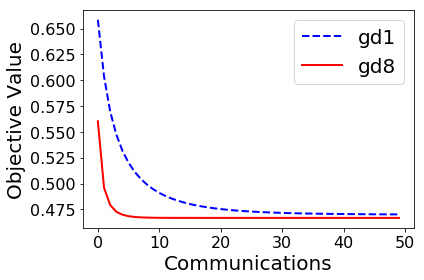

In [37]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 4))
epochs_gd1 = range(len(objvals_gd1))
epochs_gd8 = range(len(objvals_gd8))
line0, = plt.plot(epochs_gd1, objvals_gd1, '--b', LineWidth=2)
line1, = plt.plot(epochs_gd8, objvals_gd8, '-r', LineWidth=2)

plt.xlabel('Communications', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['gd1','gd8'], fontsize=20)
plt.tight_layout()
plt.show()